# Deep Learning CNN for Fashion Clothing Classification

Image Classification is one of the most popular tasks in deep learning where we are given a particular image and the model has to predict the class of the image. This notebook trains a Convolutional Neural Network (CNN) with Keras on the Fashion MNIST dataset to classify fashion images and categories.


<b>The dataset consists of:</b>

- 60,000 training examples
- 10,000 testing examples
- 28×28 grayscale images
- 10 classes

<b>These ten classes are:</b>
- T-shirt/top
- Trouser/pants
- Pullover shirt
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot

The dataset can be downloaded from [here](https://www.kaggle.com/zalando-research/fashionmnist) or you can clone the official Fashion MNIST GitHub [repo](https://github.com/zalandoresearch/fashion-mnist), the dataset appears under data/fashion. We gonna use the 60,000 images to train the CNN and the 10,000 images to evaluate how accurately the network learned to classify images.

![title](fashion.png)

# Load Dataset

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [3]:
%matplotlib inline

In [4]:
# load training and test data into dataframes
train_set = pd.read_csv('fashion-mnist_train.csv')
test_set = pd.read_csv('fashion-mnist_test.csv')

Since the class names are not included with the dataset, we gonna store them to use later

In [5]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Data Explore

In [6]:
# show the first few records of the train_set datafreame
train_set.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# show the first few records of the test_set datafreame
test_set.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# check out the dataset format
train_set.shape

(60000, 785)

In [9]:
test_set.shape

(10000, 785)

The above few lines show that there are 60,000 images in the training set, with each image represented in a single colour channel (784 pixels)

As the images of the dataset are unsigned integers in the range between 0 and 255 (black & white), we need to convert this unsigned datatype from integer to float to be allowed for the model

In [10]:
# convert integers to floats
train_arr = np.array(train_set, dtype = 'float')
test_arr = np.array(test_set, dtype = 'float')

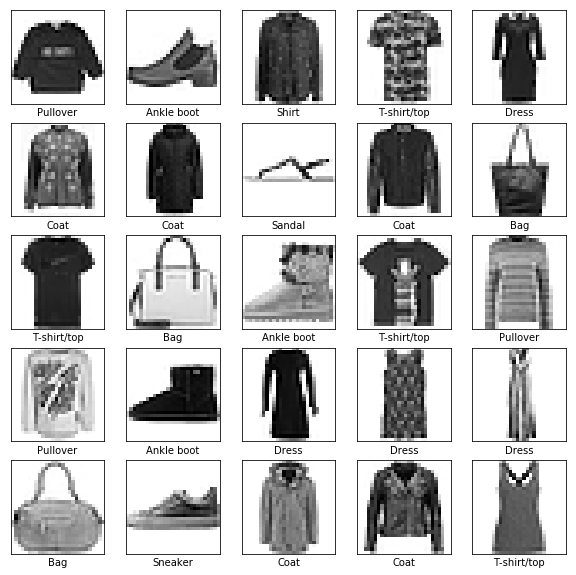

In [11]:
# show some images from the train dataset
plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_arr[i,1:].reshape((28,28)), cmap = plt.cm.binary)
    train_labels = train_set['label'][i]
    plt.xlabel(classes[train_labels])
plt.show()

# Data Preprocessing

Now we need to normalise the pixeles of these grayscale images and rescale them to the range [0,1] so we can feed them to the neural network. This can be done by divide the values of both dataframes by 255. Then slice both of the datasets into X and y to store images and labels respectively

In [12]:
# normalise to range (0:1)
# exclude label column
X_train = train_arr[:, 1:] / 255
# include label column
y_train = train_arr[:, 0]

Doing the same with the testset

In [13]:
# exclude label column
X_test = test_arr[:, 1:] / 255
# include label column
y_test = test_arr[:,0]

Next step is to split the training set into 80% training and 20% validation to optimise the classifier. We gonna keep the test set as the same to evaluate the accuracy of the model at the end on the data it has never seen. This helps to see whether the model over-fitting on the training set and whether we should lower the learning rate and train for more epochs if validation accuracy is higher than training accuracy or stop over-training if training accuracy shift higher than the validation.

In [14]:
# X_train represents the images, y_train represents the labels
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.2)

In [15]:
# check for sizes
print X_test.shape
print X_train.shape
print X_validate.shape

(10000, 784)
(48000, 784)
(12000, 784)


All images have the same size of a single colour channel, we need to reshape the arrays to have 28×28 pixels size

In [16]:
# reshape dataset to have 28×28 pixels size
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_validate = X_validate.reshape((X_validate.shape[0], 28, 28, 1))

In [17]:
# check again
print X_test.shape
print X_train.shape
print X_validate.shape

(10000, 28, 28, 1)
(48000, 28, 28, 1)
(12000, 28, 28, 1)


# Bulid the Model

To build a neural network we need to configure the layers of the model, then compile the model.

In [18]:
model = Sequential()

The model has two main aspects: the feature extraction front end comprised of convolutional and pooling layers, and the classifier backend that will make a prediction.

For the convolutional front-end, we can start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

The first layer is the flatten layer that transforms the format of the images from a 2d-array (28x28) to a 1d-array (784 pixels), this layer has no parameters to learn; it only reformats the data.

The second (and last) layer is a 10-node softmax layer as the output layer is required to be with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

Between the feature extractor and the output layer, we gonna add a fully-connected dense layer to interpret the features, in this case with 512 nodes. All layers will use the ReLU activation function







In [19]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [21]:
# first CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# second CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(64, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(10))
model.add(Activation('softmax'))

Before traing the model, we need to adjust few more parameters like loss function, optimiser and metrics. The sparse_categorical_crossentropy will be optimised as our classes are mutually and we will monitor the classification accuracy metricexclusive

In [22]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# model.compile(loss ='mse', optimizer='adam' ,metrics =['accuracy'])

Next, we gonna train the model by feeding the training data to the model so it learns to associate images and labels. Then we gonna ask the model to make predictions about the test set

In [23]:
history = model.fit(X_train, y_train, batch_size = 1024, epochs = 20, verbose = 1, validation_data = (X_validate, y_validate))
epochs = 20
# history = model.fit(X_train, y_train, batch_size = 512, epochs = 75, verbose = 1, validation_data = (X_validate, y_validate))


Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 648s 14ms/sample - loss: 0.6685 - accuracy: 0.7536 - val_loss: 1.9451 - val_accuracy: 0.8105
Epoch 2/50
48000/48000 [==============================] - 382s 8ms/sample - loss: 0.3784 - accuracy: 0.8633 - val_loss: 1.8168 - val_accuracy: 0.8647
Epoch 3/50
48000/48000 [==============================] - 359s 7ms/sample - loss: 0.3223 - accuracy: 0.8836 - val_loss: 1.6146 - val_accuracy: 0.8921
Epoch 4/50
48000/48000 [==============================] - 116s 2ms/sample - loss: 0.2914 - accuracy: 0.8938 - val_loss: 1.4534 - val_accuracy: 0.8834
Epoch 5/50
48000/48000 [==============================] - 340s 7ms/sample - loss: 0.2696 - accuracy: 0.9028 - val_loss: 1.2367 - val_accuracy: 0.8841
Epoch 6/50
48000/48000 [==============================] - 173s 4ms/sample - loss: 0.2534 - accuracy: 0.9076 - val_loss: 0.9875 - val_accuracy: 0.8966
Epoch 7/50
48000/48000 [=========================

In [24]:
# evaluate the model
evaluate = model.evaluate(X_test, y_test, verbose = 0)
print('Test Loss: {}'.format(round(evaluate[0], 3)))
print('Test Accuracy: {}'.format(round(evaluate[1], 3)))

Test Loss: 0.199
Test Accuracy: 0.943


Here we can see that our network obtained 94.3% accuracy on the testing set.

Text(0.5,1,'Accuracy evolution')

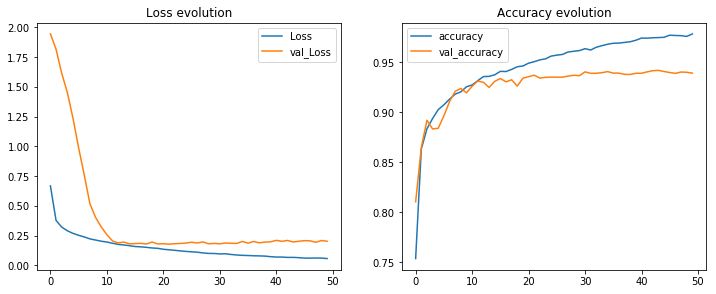

In [25]:
plt.figure(figsize = (12, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy evolution')

Show the training accuracy vs loss to get a better understanding of the model training

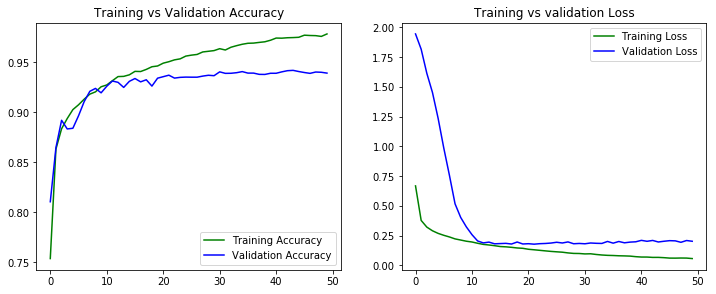

In [26]:
plt.figure(figsize = (12, 10))

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.subplot(2, 2, 1)
plt.plot(epochs, accuracy, '-g', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(epochs, loss, '-g', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs validation Loss')
plt.legend()

In [27]:
total_classes = 10
predicted_classes = model.predict_classes(X_test)
target_classes = ['Class {}'.format(i) for i in range(total_classes)]
print(classification_report(y_test, predicted_classes, target_names = target_classes))

              precision    recall  f1-score   support

     Class 0       0.87      0.93      0.90      1000
     Class 1       0.99      0.99      0.99      1000
     Class 2       0.91      0.92      0.92      1000
     Class 3       0.96      0.95      0.95      1000
     Class 4       0.89      0.94      0.92      1000
     Class 5       0.99      0.99      0.99      1000
     Class 6       0.87      0.79      0.83      1000
     Class 7       0.97      0.97      0.97      1000
     Class 8       1.00      0.99      0.99      1000
     Class 9       0.97      0.98      0.97      1000

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



Show some images with their predictions. Correct predicted classes are above and actual classes are below

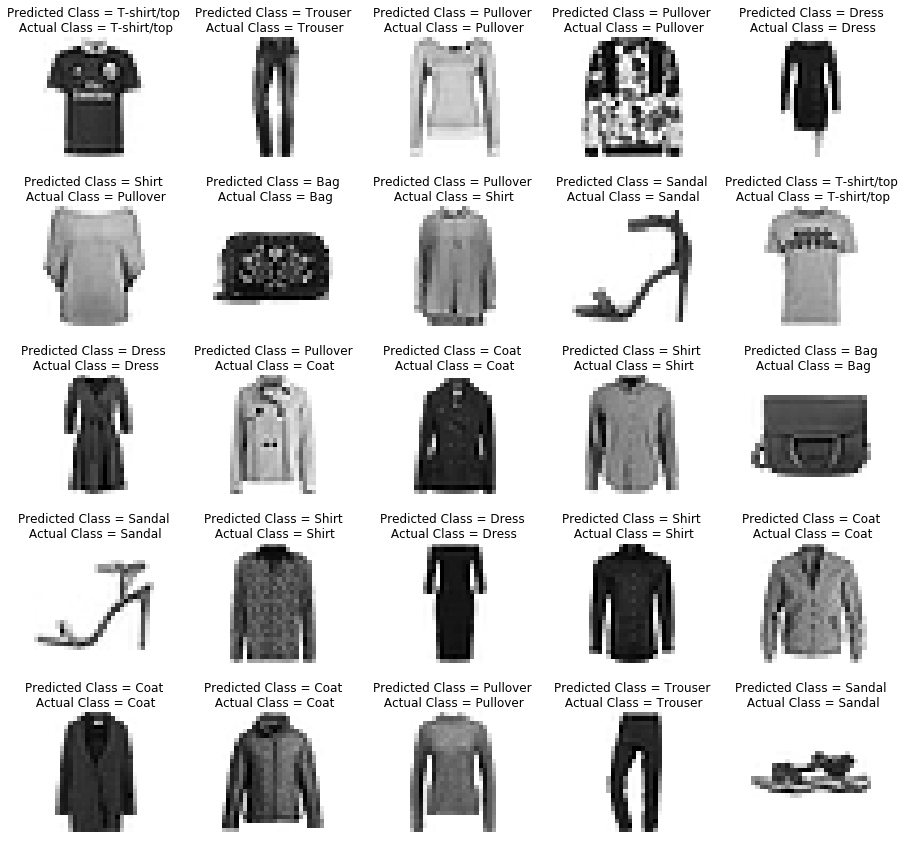

In [35]:
fig, axes = plt.subplots(5, 5, figsize = (15, 15))
axes = axes.ravel()

for i in np.arange(0, 5*5):  
    axes[i].axis('off')
    axes[i].imshow(X_test[i].reshape(28,28), cmap = plt.cm.binary)
    axes[i].set_title('Predicted Class = {}\n Actual Class = {}'.format((classes[predicted_classes[i]]), classes[int(y_test[i])]))
#     axes[i].set_title('Predicted Class = {}\n Actual Class = {}'.format(round(predicted_classes[i], 2), round(y_test[i], 2)))

# cmap=plt.cm.binary
plt.subplots_adjust(wspace = 0.5)